# About


This notebooks will analyze the  computation time in function of the block size, which is the criterion for which `rtrgsyl` stops the recursion and uses another solver to solve the small system. We will use scipy's solver. 

# Benchmark

## Imports & Utils

In [15]:
from benchmark_utils import benchmark
from utils import 
from recursive import rtrgsyl

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# Format the results of the benchmark() function
def format_results_bs(res_dic):
    df = pd.DataFrame(res_dic)
    df.time = df.time.apply(np.array)
    df['time_schur'] = df.time.apply(lambda lst: [tpl[0] for tpl in lst])
    df['time_solve'] = df.time.apply(lambda lst: [tpl[1] for tpl in lst])
    df['time_back'] = df.time.apply(lambda lst: [tpl[2] for tpl in lst])
    df.drop(columns='time', inplace=True)

    for e in df.columns:
        if e.startswith('time_'):
            df[f'{e}_mean'] = df[e].apply(np.mean)
            df[f'{e}_std'] = df[e].apply(np.std)
    
    df['m'] = df.dim.apply(lambda e: e[0])
    df['n'] = df.dim.apply(lambda e: e[1])
    
    return df

## Vary block size

In [12]:
blks_grid = 2 ** np.arange(2, 10)
blks_grid

array([  4,   8,  16,  32,  64, 128, 256, 512])

In [20]:
res = benchmark(
    solve_fun=rtrgsyl,
    vary_param=('blks', blks_grid),
    log_context={'algo': 'rtrgsyl', 'std_solver': 'syl_scipy'},
    bertel_stewart=True,
    dim=(1000, 1000),
    std_solver=solve_sylvester_scipy
)

blks=4
blks=8
blks=16
blks=32
blks=64
blks=128
blks=256
blks=512


In [24]:
df = format_results_bs(res)
df.head(2)

,dim,std_solver,blks,algo,time_schur,time_solve,time_back,time_schur_mean,time_schur_std,time_solve_mean,time_solve_std,time_back_mean,time_back_std,m,n
0,"(1000, 1000)",syl_scipy,4,rtrgsyl,"[1.3800408840179443, 1.259972095489502, 1.2740...","[4.960792303085327, 4.541321516036987, 4.54574...","[0.016704320907592773, 0.01654529571533203, 0....",1.286921,0.047376,4.595584,0.187415,0.018813,0.004769,1000,1000
1,"(1000, 1000)",syl_scipy,8,rtrgsyl,"[1.4900808334350586, 1.3187360763549805, 1.345...","[1.830186128616333, 1.7387542724609375, 2.0266...","[0.030672073364257812, 0.017257213592529297, 0...",1.402940,0.063193,1.795373,0.165433,0.025528,0.006208,1000,1000


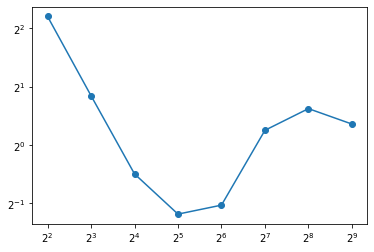

In [28]:
plt.loglog(df.blks, df.time_solve_mean, '-o', base=2)

### Sanity check: rectangular matrices

In [29]:
res_wide = benchmark(
    solve_fun=rtrgsyl,
    vary_param=('blks', blks_grid),
    log_context={'algo': 'rtrgsyl', 'std_solver': 'syl_scipy'},
    bertel_stewart=True,
    dim=(1000, 2000),
    std_solver=solve_sylvester_scipy
)

blks=4
blks=8
blks=16
blks=32
blks=64
blks=128
blks=256
blks=512


In [30]:
df_wide = format_results_bs(res_wide)
df_wide.head(2)

,dim,std_solver,blks,algo,time_schur,time_solve,time_back,time_schur_mean,time_schur_std,time_solve_mean,time_solve_std,time_back_mean,time_back_std,m,n
0,"(1000, 2000)",syl_scipy,4,rtrgsyl,"[3.8535752296447754, 4.928743362426758, 4.0185...","[9.044869899749756, 9.436055421829224, 9.23621...","[0.10110616683959961, 0.04468488693237305, 0.0...",4.642917,0.953440,9.268904,0.129646,0.070404,0.020338,1000,2000
1,"(1000, 2000)",syl_scipy,8,rtrgsyl,"[4.141205310821533, 4.135554075241089, 4.21939...","[2.9753849506378174, 3.157707691192627, 3.0661...","[0.059454917907714844, 0.05883646011352539, 0....",4.234346,0.329527,3.251241,0.255169,0.056868,0.008325,1000,2000


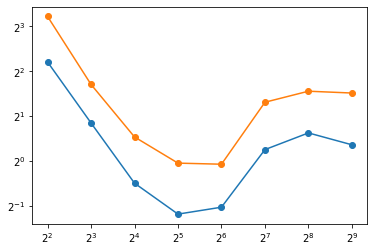

In [31]:
plt.loglog(df.blks, df.time_solve_mean, '-o', base=2)
plt.loglog(df_wide.blks, df_wide.time_solve_mean, '-o', base=2)

## Save results

In [66]:
res_dump = res + res_wide
for e in res_dump:
    e['dim'] = (int(e['dim'][0]), int(e['dim'][1]))
    e['blks'] = int(e['blks'])

with open('res/benchmark_blks.json', 'w') as f:
    json.dump(res_dump, f)

# Generate plots for report

In [34]:
from ipypublish import nb_setup
plt = nb_setup.setup_matplotlib()
import seaborn as sns
sns.set(style='whitegrid')

In [53]:
def plot_multiple_runs(df, x, y, ystd, label, base=2):
    plt.semilogx(df[x], df[y], '-o', label=label, base=base)
    plt.fill_between(df[x], df[y] - df[ystd], df[y] + df[ystd], alpha=.4)

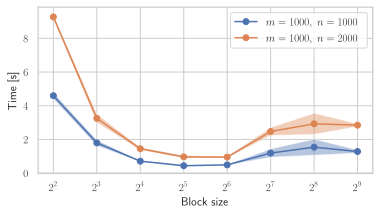

In [57]:
plt.figure(figsize=(6, 3))

plot_multiple_runs(df, 'blks', 'time_solve_mean', 'time_solve_std', label='$m=1000,\; n=1000$')
plot_multiple_runs(df_wide, 'blks', 'time_solve_mean', 'time_solve_std', label='$m=1000,\; n=2000$')

plt.xlabel('Block size'); plt.ylabel('Time [s]')
plt.legend()
plt.savefig('res/benchmark_blks.pdf', bbox_inches='tight')